# Lab 1

## Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)
!wget -nc https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt

--2022-05-09 11:05:33--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2022-05-09 11:05:33 (127 MB/s) - ‘data.txt’ saved [12905334/12905334]



The `data.txt` is a tsv file, each line of which contains a sentence in english and a corresponding translation, separated by `\t`. We'll load it into memory and create a list of pairs, which would yield the same interface as with the torchtext's datasets.

In [2]:
with open("data.txt") as f:
    data = [l.rstrip().split("\t") for l in f]

print(f"Dataset size {len(data):,}")
print("Sample:")
data[:5]

Dataset size 50,000
Sample:


[['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'],
 ['At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.'],
 ['Each has a TV and a private bathroom with shower.',
  'В вашем распоряжении также телевизор и собственная ванная комната с душем.'],
 ['Your room comes with air conditioning and satellite TV.',
  'Номер оснащен кондиционером и спутниковым телевидением.']]

## Data preprocessing

First of all, let's split our dataset into train, test and validation.

In [6]:
import torch
from torch.utils.data import random_split


data_size = len(data)
train_size = int(0.8 * data_size)
test_size = int(0.15 * data_size)
val_size = data_size - train_size - test_size
train_data, test_data, val_data = random_split(
    data, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Val size: {len(val_data)}")

Train size: 40000
Test size: 7500
Val size: 2500


Here comes the preprocessing. If you find pieces, that you don't understand, please, go back to 3rd week's practice notebook. The code is mostly taken from it.

Do not hesitate to use BPE or more complex preprocessing pipeline ;)

In [11]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()


def tokenize(sent):
    return tokenizer.tokenize(sent.lower())

In [12]:
from collections import Counter

from torchtext.vocab import vocab as Vocab


src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=3)
trg_vocab = Vocab(trg_counter, min_freq=3)

In [ ]:
unk_token = "<unk>"
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

print(f"Source (en) vocabulary size: {len(src_vocab)}")
print(f"Target (ru) vocabulary size: {len(trg_vocab)}")

Source (en) vocabulary size: 6711
Target (ru) vocabulary size: 9310


In [35]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])
    return src_padded, trg_padded


batch_size = 128
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([40, 128]), torch.Size([38, 128]))

## Model side

## 1. CNN Encoder.
Модель состоит из CNN энкодера с 16 слоями, в качестве декодера используется одна GRU. По какой-то причине она не смогла обучиться, bleu почти нулевой. 

In [ ]:
device

'cuda'

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=200):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
import torch.nn as nn
import numpy as np


class Encoder(nn.Module):
  def __init__(self, n_tokens, emb_dim, hid_dim, num_layers, device, dropout):
    super().__init__()
    self.hid_dim = hid_dim
    self.tok_embedding = nn.Embedding(n_tokens, emb_dim)
    self.pos_encoding = PositionalEncoding(emb_dim)
    self.emb2hid = nn.Linear(emb_dim, hid_dim)
    self.hid2emb = nn.Linear(hid_dim, emb_dim)
    self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = 3, 
                                              padding = 1)
                                    for _ in range(num_layers)])
    self.dropout = nn.Dropout(dropout)
    self.device = device


  def forward(self, src):
    embedded = self.tok_embedding(src)
    pos_enc_embedded = self.pos_encoding(embedded)
    out = self.emb2hid(pos_enc_embedded)
    out = out.permute(1, 2, 0)

    for conv in self.convs:
      conved = conv(self.dropout(out))
      conved = F.glu(conved, dim=1)
      conved = (conved + out) * torch.FloatTensor([0.1]).to(self.device)
      out = conved

    out = self.hid2emb(out.permute(0, 2, 1))
    #out = [batch size, src len, emb dim]
    #out_emb = [batch size, src len, emb dim]
    out_emb = (out + pos_enc_embedded.permute(1, 0, 2)) * torch.FloatTensor([0.1]).to(self.device)
    return out.permute(1, 0, 2), out_emb.permute(1, 0, 2)


In [ ]:
import random
import torch.nn.functional as F
import torch.nn as nn



class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout,  device):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.energy = nn.Linear(hid_dim, 1)
        self.rnn = nn.GRU(hid_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)
        self.device = device

    def forward(self, input, encoder_states, hidden):

        seq_length = encoder_states.shape[0]
        h_reshaped = hidden[self.n_layers-1:self.n_layers].repeat(seq_length, 1, 1)

        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        energy = torch.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        attention = F.softmax(energy)
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)
        rnn_input = torch.cat((context_vector, embedded), dim=2)


        output, hidden = self.rnn(rnn_input)
        hidden = F.glu(hidden, dim=2)
        pred = self.out(output.squeeze(dim=0))
        hidden = nn.Linear(self.n_layers, seq_length).to(self.device)(hidden.permute(2, 1, 0))
        return pred, hidden.permute(2, 1, 0)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        #assert (
        #    encoder.n_layers == decoder.n_layers
        #), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        encoder_states, hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, encoder_states, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
enc = Encoder(len(src_vocab), emb_dim=256, hid_dim=512, num_layers=16, device=device, dropout=0.5)
dec = Decoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=1, dropout=0, device=device)
model = Seq2Seq(enc, dec).cuda()

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights);

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 35,898,975 trainable parameters


In [ ]:
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR

optimizer = torch.optim.Adam(model.parameters())
scheduler = MultiStepLR(optimizer, milestones=[5, 8], gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])
loss_history, train_loss_history, val_loss_history = [], [], []

In [ ]:
device

'cuda'

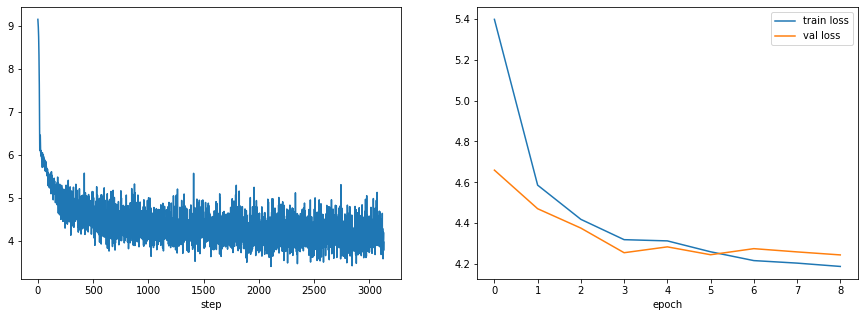

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_


# Please don't use tensorboard here.
# It doesn't save the training plots in the notebook.
n_epochs = 10
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for src, trg in train_dataloader:
        src, trg = src.to('cuda'), trg.to('cuda')
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in val_dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)
    scheduler.step()
    #print(scheduler.get_last_lr())

In [ ]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 40
with torch.no_grad():
    for i, (src, trg) in enumerate(val_data):
        encoded = encode(src, src_vocab)[::-1]
        encoded = torch.tensor(encoded)[:, None].to(device)
        out, hidden = model.encoder(encoded)

        pred_tokens = [trg_vocab[sos_token]]
        for _ in range(max_len):
            decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
            pred, hidden = model.decoder(decoder_input, out, hidden)
            _, pred_token = pred.max(dim=1)
            if pred_token == trg_vocab[eos_token]:
                # Don't add it to prediction for cleaner output.
                break

            pred_tokens.append(pred_token.item())

        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

        if i == 10:
            break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


src: 'all apartments have a dvd player and satellite tv, a kitchen with a microwave, and a washing machine and a tumble dryer.'
trg: 'все они оснащены телевизором со спутниковыми каналами и dvd-плеером, а также располагают кухней с микроволновой печью и стиральной/сушильной машиной.'
pred: 'в <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>'

src: 'they are fitted with blackout curtains, free drinking water and free toiletries.'
trg: 'гостям предоставляется бесплатная питьевая вода и бесплатные туалетно-косметическими принадлежности.'
pred: 'в <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>'

src: 'a small refrigerator, c

In [ ]:
from nltk.translate.bleu_score import corpus_bleu


references, hypotheses = [], []
with torch.no_grad():
    for src, trg in test_dataloader:
        output = model(src.to(device), trg.to(device), teacher_forcing_ratio=0)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i]
            reference_tokens = [trg_itos[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in specials]
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis_tokens = [trg_itos[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in specials]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Your model shows test BLEU of 0.1


Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

## 2.Seq2Seq with Packing/Padding + Masked Attention + MultiStep scheduler

Обычный seq2seq, но с packing и padding. Также была добавлена маска для того, чтобы при вычислении attention
не учитывался padding последовательности. Удалось достичь $23.3$ bleu.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list, src_len = [], [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)
        src_list.append(torch.tensor(src_encoded))
        src_len.append(len(src_encoded))
        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])
    return src_padded, trg_padded, src_len


batch_size = 128
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

src_batch, trg_batch, src_len = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape, len(src_len)

(torch.Size([46, 128]), torch.Size([45, 128]), 128)

In [22]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)

    def forward(self, src, src_len):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        packed_embedded = pack_padded_sequence(embedded, src_len, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed_embedded)
        out, _ = pad_packed_sequence(packed_out)
        return out, hidden


In [23]:
class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hid_dim*2, hid_dim)
        self.energy = nn.Linear(hid_dim, 1)
        self.rnn = nn.LSTM(hid_dim + emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)

    def forward(self, input, encoder_states, hidden, mask):

        #encoder_states = [src_len, batch_size, hid_dim]
        seq_length = encoder_states.shape[0]
        hidden_state, cell_state = hidden
        h_reshaped = hidden_state[1:2].repeat(seq_length, 1, 1)

 
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        energy = torch.relu(self.attn(torch.cat((h_reshaped, encoder_states), dim=2)))
        energy = self.energy(energy)

        energy = energy.masked_fill_(mask == 0, -1e10)
        attention = F.softmax(energy)
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)
        rnn_input = torch.cat((context_vector, embedded), dim=2)


        output, hidden = self.rnn(rnn_input, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def create_mask(self, src):
      mask = src != self.pad_idx
      return mask

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        encoder_states, hidden = self.encoder(src, src_len)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        mask = self.create_mask(src).unsqueeze(2)
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, encoder_states, hidden, mask)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [ ]:
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
enc = Encoder(len(src_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
dec = Decoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
model = Seq2Seq(enc, dec, pad_idx=src_vocab[pad_token]).cuda()

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights);

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 18,332,511 trainable parameters


In [ ]:
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR

optimizer = torch.optim.Adam(model.parameters())
scheduler = MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])
loss_history, train_loss_history, val_loss_history = [], [], []

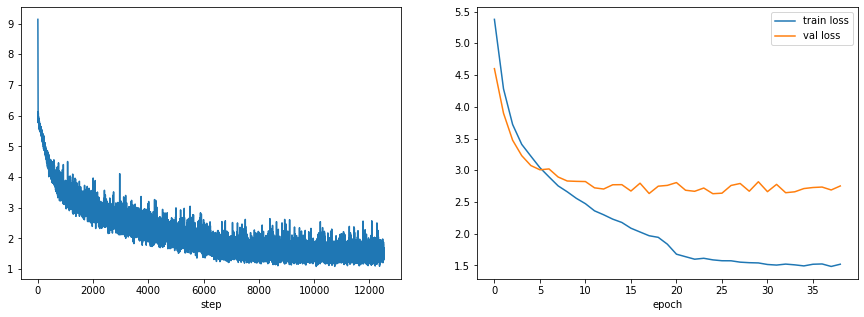

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
from torch.nn import functional as F
import random


# Please don't use tensorboard here.
# It doesn't save the training plots in the notebook.
n_epochs = 40
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for src, trg, src_len in train_dataloader:
        src, trg = src.to('cuda'), trg.to('cuda')
        output = model(src, src_len, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg, src_len in val_dataloader:
            src, trg = src.to(device), trg.to(device),
            output = model(src, src_len, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)
    scheduler.step()
    #print(scheduler.get_last_lr())

In [ ]:
from nltk.translate.bleu_score import corpus_bleu


references, hypotheses = [], []
with torch.no_grad():
    for src, trg, src_len in test_dataloader:
        output = model(src.to(device), src_len, trg.to(device), teacher_forcing_ratio=0)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i]
            reference_tokens = [trg_itos[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in specials]
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis_tokens = [trg_itos[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in specials]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Your model shows test BLEU of 23.3


## 3.Seq2Seq with Packing/Padding + Masked Attention + MultiStep scheduler+BPE

После добавления BPE качество модели значительно увеличилось, с $23.3$ bleu до $29.7$ bleu.

In [11]:
!pip install sentencepiece

In [4]:
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor

In [7]:
with open("train_data.txt", "w") as f:
  for sent in train_data:
    f.write(sent[0] + "\n")
  f.close()


In [8]:
with open("val_data.txt", "w") as f:
  for sent in val_data:
    f.write(sent[0] + "\n")
  f.close()


In [9]:
with open("test_data.txt", "w") as f:
  for sent in test_data:
    f.write(sent[0] + "\n")
  f.close()


In [13]:
input_file = 'train_data.txt'
max_num_words = len(src_vocab)
model_type = 'bpe'
model_prefix = 'src_sentencepiece'
pad_id = 0
unk_id = 1
bos_id = 2
eos_id = 3

sentencepiece_params = ' '.join([
    '--input={}'.format(input_file),
    '--model_type={}'.format(model_type),
    '--model_prefix={}'.format(model_prefix),
    '--vocab_size={}'.format(max_num_words),
    '--pad_id={}'.format(pad_id),
    '--unk_id={}'.format(unk_id),
    '--bos_id={}'.format(bos_id),
    '--eos_id={}'.format(eos_id)
])
print(sentencepiece_params)
SentencePieceTrainer.train(sentencepiece_params)

--input=train_data.txt --model_type=bpe --model_prefix=src_sentencepiece --vocab_size=6707 --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3


In [14]:
sp = SentencePieceProcessor()
sp.load("{}.model".format(model_prefix))
print('Found %s unique tokens.' % sp.get_piece_size())

Found 6707 unique tokens.


In [15]:
input_file = 'train_data.txt'
max_num_words = len(trg_vocab)
model_type = 'bpe'
model_trg_prefix = 'trg_sentencepiece'
pad_id = 0
unk_id = 1
bos_id = 2
eos_id = 3

sentencepiece_params = ' '.join([
    '--input={}'.format(input_file),
    '--model_type={}'.format(model_type),
    '--model_prefix={}'.format(model_trg_prefix),
    '--vocab_size={}'.format(max_num_words),
    '--pad_id={}'.format(pad_id),
    '--unk_id={}'.format(unk_id),
    '--bos_id={}'.format(bos_id),
    '--eos_id={}'.format(eos_id)
])
print(sentencepiece_params)
SentencePieceTrainer.train(sentencepiece_params)

--input=train_data.txt --model_type=bpe --model_prefix=trg_sentencepiece --vocab_size=9306 --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3


In [16]:
sp_trg = SentencePieceProcessor()
sp_trg.load("{}.model".format(model_trg_prefix))
print('Found %s unique tokens.' % sp_trg.get_piece_size())

Found 9306 unique tokens.


In [17]:
from collections import Counter

from torchtext.vocab import vocab as Vocab


src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=3)
trg_vocab = Vocab(trg_counter, min_freq=3)

In [18]:
unk_token = "<unk>"
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=1)
        vocab.set_default_index(0)

    vocab.insert_token(sos_token, 2)
    vocab.insert_token(eos_token, 3)
    vocab.insert_token(pad_token, 0)

print(f"Source (en) vocabulary size: {len(src_vocab)}")
print(f"Target (ru) vocabulary size: {len(trg_vocab)}")

Source (en) vocabulary size: 6711
Target (ru) vocabulary size: 9310


In [19]:
def collate_batch(batch):
    src_list, trg_list, src_len = [], [], []
    for src, trg in batch:
        src_piece = sp.encode_as_pieces(src)
        src_encoded = sp.piece_to_id(src_piece)
        src_list.append(torch.tensor(src_encoded))
        src_len.append(len(src_encoded))

        trg_piece = sp_trg.encode_as_pieces(trg)
        trg_encoded = sp_trg.piece_to_id(trg_piece)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])
    return src_padded, trg_padded, src_len

In [20]:
from torch.utils.data import DataLoader
batch_size=64
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

In [24]:
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
enc = Encoder(len(src_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
dec = Decoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
model = Seq2Seq(enc, dec, pad_idx=src_vocab[pad_token]).cuda()

In [25]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights);

In [26]:
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR

optimizer = torch.optim.Adam(model.parameters())
scheduler = MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])
loss_history, train_loss_history, val_loss_history = [], [], []

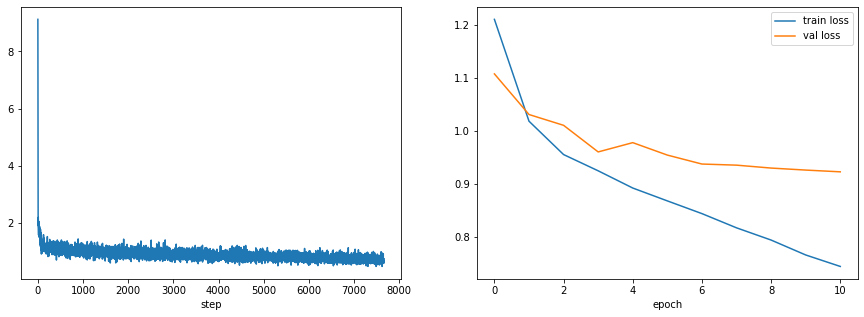

In [32]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
import random


# Please don't use tensorboard here.
# It doesn't save the training plots in the notebook.
n_epochs = 40
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for src, trg, src_len in train_dataloader:
        src, trg = src.to('cuda'), trg.to('cuda')
        output = model(src, src_len, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg, src_len in val_dataloader:
            src, trg = src.to(device), trg.to(device),
            output = model(src, src_len, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)
    scheduler.step()
    #print(scheduler.get_last_lr())

In [33]:
from nltk.translate.bleu_score import corpus_bleu
trg_itos = trg_vocab.get_itos()

references, hypotheses = [], []
with torch.no_grad():
    for src, trg, src_len in test_dataloader:
        output = model(src.to(device), src_len, trg.to(device), teacher_forcing_ratio=0)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i]
            reference_tokens = [trg_itos[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in specials]
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis_tokens = [trg_itos[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in specials]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Your model shows test BLEU of 29.7


**Вывод:** все перечисленные техники действительно улучшают качество модели, однако незначительно (обычно на 1-2 пункта bleu). В этом смысле лучшей техникой оказался BPE, который обеспечил прирост bleu сразу на 6 пунктов. При этом, по каким-то непонятным причинам модель с CNN энкодером не смогла обучиться, возможно дело в неправильной имплементации. 